## 加载数据

    1、定义了新的数据格式：
        1.1 利用将所有数据按照窗口大小分成k个互不重合的窗口区域。
        1.2 每个seq包含t个窗口区域，并使用这长为t的seq去预测下一个区域
        
    2、新的方式同样不能解决迭代预测带来的问题………

In [92]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [135]:
'''
定义一些全局变量
'''
window_size=2
seq_len=5
split_per=0.9

In [136]:
'''
加载最原始的数据
'''
raw_data=pd.read_csv('./data/all_stock_data.csv')
raw_data.shape

(17364, 7)

In [137]:
'''
暂时就提供min-max的normalization方法
'''

def data_nor(y,way='min_max'):
    y_min=min(y)
    y_max=max(y)
    y=(np.asarray(y)-y_min)/(y_max-y_min)
    return y

def data_nor_2(y,way='nor'):
    y_mean=np.mean(y)
    y_std=np.std(y)
    y=(np.asarray(y)-y_mean)/y_std
    return y

In [142]:
'''
返回训练的x,y,测试的x,y
'''
def get_train_test(y_org,window_size,seq_len,split_per=0.9):
    x_final=[]
    y_final=[]
    
    win_list=[]
    # 拿到切分了多少了window
    win_cnt=int(len(y_org)/window_size)
    for i in range(win_cnt):
        win_list.append(y_org[i*window_size:(i+1)*window_size])
    
    
    # 这里来划分seq，每个seq之间有重合的部分
    # [0,1,2,3,4,5,6,7,8,9], 
    # window_size=2  => [[0,1],[2,3],[4,5],[6,7],[8,9]]
    # seq_len=2 => [[0,1],[2,3]] ,[[2,3],[4,5]],[[4,5],[6,7]]..
#     for i in range(win_cnt-seq_len):
#         temp_seq=win_list[i:i+seq_len]
#         temp_seq_label=win_list[i+seq_len]
#         x_final.append(temp_seq)
#         y_final.append(temp_seq_label)
    
    
    # 这里来划分seq，每个seq之间也没有重合的部分…
    # [0,1,2,3,4,5,6,7,8,9], 
    # window_size=2  => [[0,1],[2,3],[4,5],[6,7],[8,9]]
    # seq_len=2 => [[0,1],[2,3]] ,[[4,5],[6,7]]
    for i in range(int(win_cnt/seq_len)-1):
        temp_seq=win_list[i*seq_len:(i+1)*seq_len]
        temp_seq_label=win_list[(i+1)*seq_len]
        x_final.append(temp_seq)
        y_final.append(temp_seq_label)
    
    # 切分训练和预测
    cut_id=min(int(len(x_final)*split_per),len(x_final)-1)
    
    x_final_train=np.asarray(x_final[:cut_id])
    y_final_train=np.asarray(y_final[:cut_id])
    
    x_final_test=np.asarray(x_final[cut_id:])
    y_final_test=np.asarray(y_final[cut_id:])
    
    return [x_final_train,y_final_train,x_final_test,y_final_test]

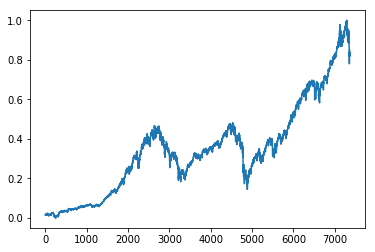

In [143]:
'''
加载原始数据，绘图查看
'''
y_org=raw_data.loc[10000:,'Close'].tolist()
y_org_nor=data_nor(y_org)
plt.plot(y_org_nor)

In [144]:
'''
归一化原始数据，生成训练集和测试集
'''
y_org_nor=data_nor(y_org)
train_test_result=get_train_test(y_org_nor,window_size,seq_len)

In [61]:
train_test_result[0].shape

(2205, 3, 3)

## 构建模型

    1、模型的结构还是一样，但是最后预测的内容结果需要改变。
    2、原来相当于只预测一天，现在要预测一个windows_size
    3、看了教程里面，没那么复杂，就是用lstm最后一个时间步的状态值，
      去接一个Dense，输出的维度等于word_vector的维度就好

In [145]:
'''
构建模型
'''
def build_model():
    model=Sequential()
    model.add(LSTM(units=128,input_shape=(seq_len,window_size),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128,return_sequences=True))
    model.add(LSTM(units=128,return_sequences=False))
    model.add(Dense(window_size,activation='linear'))
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model


In [146]:
'''
训练模型
'''
def train_model(train_test_data,model,epochs=20,batch_size=10,shuffle=False):
    x_train=train_test[0]
    y_train=train_test[1]
    x_valid=train_test[2]
    y_valid=train_test[3]
    
    model.fit(x_train,y_train,validation_data=(x_valid,y_valid),epochs=epochs,batch_size=batch_size,shuffle=shuffle)
    return model

In [147]:
'''
测试
'''
y_org=raw_data.loc[10000:16000,'Close'].tolist()
y_org_nor=data_nor_2(y_org)

# x=np.asarray(range(0,5001))/100
# y=np.asarray([math.sin(aa) for aa in x])
# y_org_nor=data_nor_2(y)

train_test=get_train_test(y_org_nor,window_size,seq_len,split_per=0.8)

model=build_model()
train_model(train_test,model,epochs=10)

Train on 479 samples, validate on 120 samples
Epoch 1/10
479/479 [==============================] - 4s 7ms/step - loss: 0.4341 - mean_absolute_error: 0.4560 - val_loss: 0.0233 - val_mean_absolute_error: 0.1275
Epoch 2/10
479/479 [==============================] - 0s 1ms/step - loss: 0.0394 - mean_absolute_error: 0.1475 - val_loss: 0.0191 - val_mean_absolute_error: 0.1120
Epoch 3/10
479/479 [==============================] - 0s 979us/step - loss: 0.0689 - mean_absolute_error: 0.2169 - val_loss: 0.0494 - val_mean_absolute_error: 0.1958
Epoch 4/10
479/479 [==============================] - 0s 975us/step - loss: 0.2973 - mean_absolute_error: 0.4644 - val_loss: 0.3189 - val_mean_absolute_error: 0.4774
Epoch 5/10
479/479 [==============================] - 0s 1ms/step - loss: 0.2814 - mean_absolute_error: 0.4382 - val_loss: 0.1252 - val_mean_absolute_error: 0.2892
Epoch 6/10
479/479 [==============================] - 0s 981us/step - loss: 0.1983 - mean_absolute_error: 0.3589 - val_loss: 0.083

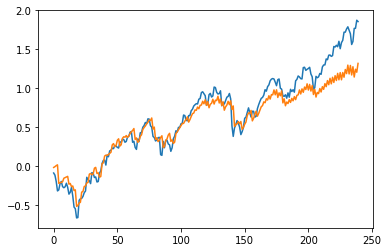

In [151]:
'''
预测方式1：逐点预测
'''
def predict_1(train_test,model):
    
    x_test=train_test[2]
    y_test=train_test[3]
    
    pred_result=model.predict_on_batch(x_test)
    
    y_test_flat=np.reshape(y_test,(y_test.shape[0]*y_test.shape[1],-1))
    plt.plot(y_test_flat)
    
    y_pred_flat=np.reshape(pred_result,(pred_result.shape[0]*pred_result.shape[1],-1))
    plt.plot(y_pred_flat)
    
    
    
predict_1(train_test,model)

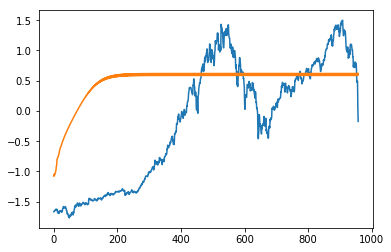

In [184]:
'''
预测方式2：替换预测
'''
def predict_2(train_test,model):
    
    x_test=train_test[0]
    y_test=train_test[1]
    
    final_result=np.asarray(list())
    for i in range(len(x_test)):
        if i==0:
            temp_in=x_test[i]
            temp_in=np.reshape(temp_in,(1,temp_in.shape[0],temp_in.shape[1]))
        else:
            temp_in=np.delete(temp_in,0,axis=1)
            temp_in=np.append(temp_in,temp_result)
            temp_in=np.reshape(temp_in,(1,seq_len,window_size))
        
#         print(temp_in)
        
        temp_result=model.predict(temp_in)
        
        final_result=np.append(final_result,temp_result)
    
    
    y_test_flat=np.reshape(y_test,(y_test.shape[0]*y_test.shape[1],-1))
    plt.plot(y_test_flat)
    
    plt.plot(final_result)


predict_2(train_test,model)

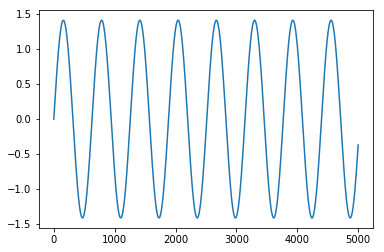

In [110]:
x=np.asarray(range(0,5001))/100
y=np.asarray([math.sin(aa) for aa in x])
